# Analysis of Mira

### Preamble
Imports and constants

In [1]:
from py_fish.plotting import plot_speed_profile, plot_profiles
from py_fish.operation import (
    speed_profile_from_data,
    extract_transit_speed,
    distance_from_profile,
    total_consumption_from_profile,
)
from py_fish.loads import calculate_propulsion_power
from py_fish.utils import components_to_profile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import folium
from scipy.ndimage import uniform_filter1d

In [2]:
ENGINE_RATING = 167.0
LENGTH = 11.00
BEAM = 4.1
DATE = "2024-03-12"
MOTOR_EFFICIENCY = 0.96
BATTERY_EFFICIENCY = 0.96
VESSEL = "mira"

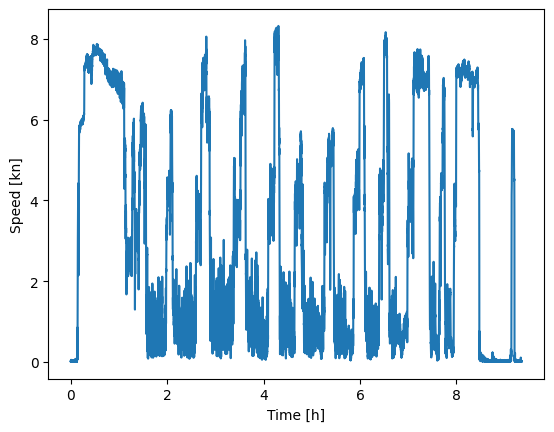

In [3]:
fig, ax = plt.subplots()
speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
plot_speed_profile(speed_profile=speed_profile, ax=ax)

Distances and time:
	Transit out: 6.95 nm, 1.15 h
	Fishing: 17.39 nm, 6.83 h
	Transit in: 3.81 nm, 1.38 h



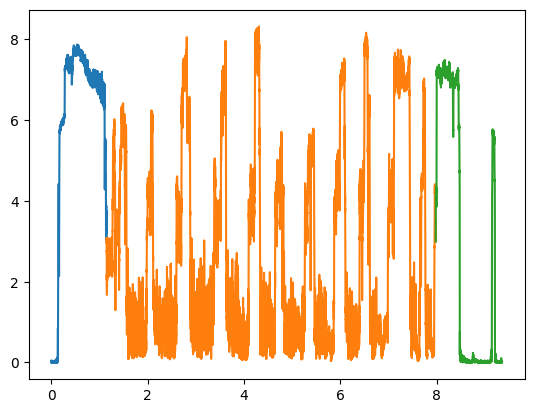

In [4]:
fig, ax = plt.subplots()
transit_out, fishing, transit_in = extract_transit_speed(speed_profile=speed_profile)
plot_profiles(ax, transit_out=transit_out, fishing=fishing, transit_in=transit_in)

distance_out = distance_from_profile(transit_out)
distance_fishing = distance_from_profile(fishing)
distance_in = distance_from_profile(transit_in)

time_out = transit_out[-1, 0] - transit_out[0, 0]
time_fishing = fishing[-1, 0] - fishing[0, 0]
time_in = transit_in[-1, 0] - transit_in[0, 0]

print(
    f"Distances and time:\n\tTransit out: {distance_out:.2f} nm, {time_out:.2f} h\n\tFishing: {distance_fishing:.2f} nm, {time_fishing:.2f} h\n\tTransit in: {distance_in:.2f} nm, {time_in:.2f} h\n"
)

Consumption propulsion: 76.63 kWh
Corrected consumption propulsion: 85.49 kWh


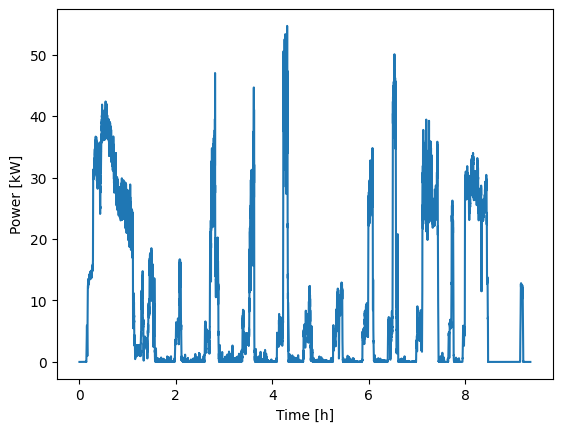

In [5]:
fig, ax = plt.subplots()
power_profile = components_to_profile(
    speed_profile[:, 0],
    calculate_propulsion_power(length=LENGTH, beam=BEAM, speeds=speed_profile[:, 1]),
)
plot_profiles(ax, power_profile=power_profile)
ax.set_ylabel("Power [kW]")
ax.set_xlabel("Time [h]")

corrected_power_profile = components_to_profile(
    power_profile[:, 0], power_profile[:, 1] * 1.1156
)
propulsion_total = total_consumption_from_profile(power_profile)
corrected_propulsion_total = total_consumption_from_profile(corrected_power_profile)

print(f"Consumption propulsion: {propulsion_total:.2f} kWh")
print(f"Corrected consumption propulsion: {corrected_propulsion_total:.2f} kWh")

In [6]:
from pathlib import Path

from py_fish.engine import EngineApplication, calculate_consumption
from py_fish.loads import calculate_dc_energy, calculate_hydraulics_energy

dates_fishing = ["2024-03-12", "2024-03-18"]

data_dir = Path(os.path.abspath("")).resolve() / "py_fish" / "mira"
files = [f for f in data_dir.iterdir() if f.is_file()]
output = open("mira_consumptions.csv", "w")
output.write(
    "date,propulsion,propulsion_fit,hydraulics,dc,total,total_fit,kwh,kwh_fit\n"
)
output.close()
output = open("mira_consumptions.csv", "a")
for file in files:
    DATE = file.name[3:13]
    if DATE not in dates_fishing:
        continue
    measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
    (transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
    time_fishing = fishing[-1, 0] - fishing[0, 0]

    model_power = calculate_propulsion_power(
        speeds=uniform_filter1d(measured_speed_profile[:, 1], size=30),
        length=LENGTH,
        beam=BEAM,
    )

    power_increase = 1.1156

    model_power_fit = model_power * power_increase

    model_power_total = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power)
    )
    model_power_total_fit = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power_fit)
    )
    model_consumption_profile = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_profile_fit = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power_fit,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_propulsion = total_consumption_from_profile(
        model_consumption_profile
    )
    model_consumption_propulsion_fit = total_consumption_from_profile(
        model_consumption_profile_fit
    )
    power_hydraulics = calculate_hydraulics_energy(
        hours_fishing=time_fishing, hydraulic_deck_load_power=2.0
    )
    power_dc = calculate_dc_energy(
        hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
    )
    hydraulics_consumption = calculate_consumption(
        powers=power_hydraulics,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    dc_consumption = calculate_consumption(
        powers=power_dc,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    output.write(
        f"{DATE},{model_consumption_propulsion},{model_consumption_propulsion_fit},{hydraulics_consumption},{dc_consumption},{model_consumption_propulsion + hydraulics_consumption + dc_consumption},{model_consumption_propulsion_fit + hydraulics_consumption + dc_consumption},{(model_power_total + power_dc + power_hydraulics)/(MOTOR_EFFICIENCY * BATTERY_EFFICIENCY)},{(model_power_total_fit + power_dc + power_hydraulics)/(MOTOR_EFFICIENCY * BATTERY_EFFICIENCY)}\n"
    )

output.close()

In [7]:
from py_fish.data import load_one_day

df = load_one_day(vessel=VESSEL, date=DATE)
coordinates = df.select(["time", "latitude", "longitude"]).to_numpy()
coordinates[:, 0] = (coordinates[:, 0] - coordinates[0, 0]) / (3600 * 1e6)

m = folium.Map(
    location=coordinates[0, 1:],
    control_scale=True,
    # zoom_start=11,
    # min_zoom=11,
    tiles="cartodb positron",
)
folium.PolyLine(coordinates[:, 1:], tooltip="", color="#FF0000").add_to(m)
m